In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
wave_length = sp.constants.speed_of_sound / 40_000
omega = 2 * np.pi * wave_length # angular frequency
k = 2 * np.pi / wave_length  # wave number
phase_res = 8
amp_res = 8

In [3]:
# far field piston-source model: from https://jontallen.ece.illinois.edu/uploads/473.F18/Lectures/Chapter_7b.pdf
def p(r, theta, t):
    p_0 = 1.293 # density of air
    U_0 = 1 # intensity, specifically, the speed at which the piston moves
    a = 0.005 # 5 mm: radius of the emitter
    # a = 1
    if np.sin(theta) == 0: # avoid a divide by 0
        return 1j * omega * p_0 * a**2 * U_0 / (2 * r) * np.e**(1j * (omega * t - k * r))
    else:
        return 1j * omega * p_0 * a**2 * U_0 / (2 * r) * np.e**(1j * (omega * t - k * r)) * 2 * sp.special.j1(k * a * np.sin(theta)) / ( k * a * np.sin(theta))

/home/qferbs/venv/acoustic_sim/lib/python3.12/site-packages/matplotlib/contour.py:1578: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/home/qferbs/venv/acoustic_sim/lib/python3.12/site-packages/matplotlib/contour.py:1579: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/home/qferbs/venv/acoustic_sim/lib/python3.12/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


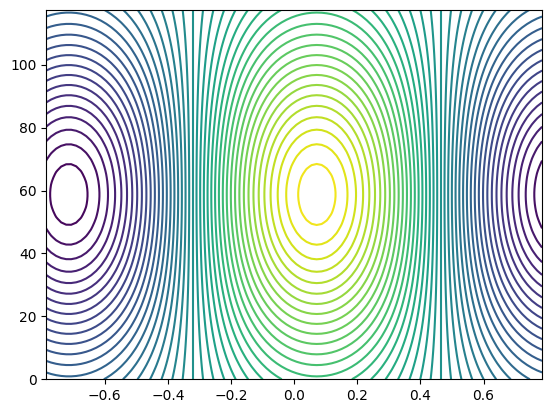

In [4]:
t = np.linspace(0, 2 * np.pi / omega, 100)
theta = np.linspace(-np.pi/4, np.pi/4, 100)
pressures = []
for th in theta:
    pressures.append(p(0.16, th, t))

plt.contour(theta, t, np.array(pressures), 50)

In [5]:
control_points = [np.array([0.025, 0.05, 0.1]), np.array([0.075, 0.05, 0.1])]
tx, ty = np.meshgrid(np.linspace(0.005, 0.095, 10), np.linspace(0.005, 0.095, 10))
transducers = np.dstack([tx, ty, np.zeros([10, 10])])

In [6]:
# create propagators
propagators = np.zeros([len(control_points), 10, 10], dtype=complex)
for i, cp in enumerate(control_points):
    for x, y in np.ndindex(transducers.shape[:2]):
        vec_r = cp - transducers[x, y]
        r = np.linalg.norm(vec_r)
        theta = np.arccos(vec_r[2]/r)
        propagators[i, x, y] = p(r, theta, 0)

In [7]:
c_pressures = np.zeros([len(control_points)], dtype=complex)
t_pressures = np.ones(transducers.shape[:2], dtype=complex)
phase_res = 8
amp_res = 8

for _ in range(10):
    pressures = []
    for i, cp in enumerate(control_points):
        # forward propagate
        c = 0
        for x, y in np.ndindex(transducers.shape[:2]):
            c += t_pressures[x, y] * propagators[i, x, y]
        # TODO: add n for multiple control points
        c_pressures[i] = c / abs(c)
        
        # backwards propagate
        # t_pressures_back = np.zeros([16, 16], dtype=complex)
        for x, y in np.ndindex(transducers.shape[:2]):
            pl = 0
            for i, cp in enumerate(control_points):
                pl += c_pressures[i] * np.conjugate(propagators[i, x, y])
            t_pressures[x, y] = pl

        # normalize
        t_pressures = t_pressures / np.max(np.abs(t_pressures))

        # quantize  
        phase = np.round(np.angle(t_pressures) / (2*np.pi) * phase_res) / phase_res * 2 * np.pi
        # TODO: maybe turn on all emitters for no amplitude res
        # amp = np.round(np.abs(t_pressures) * amp_res) / amp_res
        amp = 1
    
        t_pressures = amp * np.e**(1j*phase)

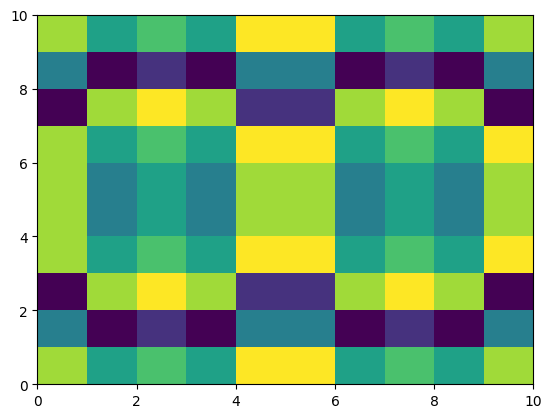

In [8]:
plt.pcolormesh(np.angle(t_pressures))

In [9]:
# produce a 3D mesh of resultant pressures
n = 80
size = 0.10
mesh = np.zeros([n, n, n*2], dtype=complex)
for x, y, z in np.ndindex(mesh.shape):
    mesh_point = np.array([x, y, z]) * size / n
    for i, j in np.ndindex(transducers.shape[:2]):
        vec_r = mesh_point - transducers[i, j]
        r = np.linalg.norm(vec_r)
        theta = np.arccos(vec_r[2]/r)
        if r != 0:
            mesh[x, y, z] += t_pressures[i, j] * p(r, theta, 0)

/tmp/ipykernel_3340/161473073.py:10: RuntimeWarning: invalid value encountered in scalar divide
  theta = np.arccos(vec_r[2]/r)


Text(0.5, 0.92, 'Pressure using HAT algorithm')

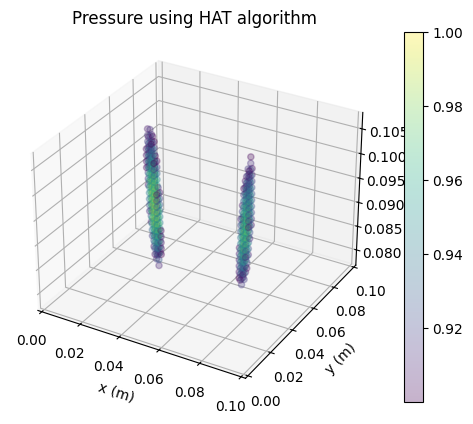

<Figure size 640x480 with 0 Axes>

In [10]:
ax = plt.figure().add_subplot(projection='3d')

meshn = mesh[:, :, 5:]
norm = np.abs(meshn)/np.max(np.abs(meshn))
x, y, z = np.where(norm>0.9)

sc = ax.scatter(x*size/n, y*size/n, z*size/n, c=norm[x, y, z], alpha=0.3, cmap='viridis')
ax.set_xlim(0, 0.1)
ax.set_ylim(0, 0.1)
# sc = ax.contour(x*size/n, y*size/n, z*size/n, c=norm[x, y, z], alpha=0.5, cmap='viridis')
plt.figure().colorbar(sc)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
ax.set_title("Pressure using HAT algorithm")

Text(0.5, 1.0, 'Pressure using HAT algorithm, y = 0.075 m')

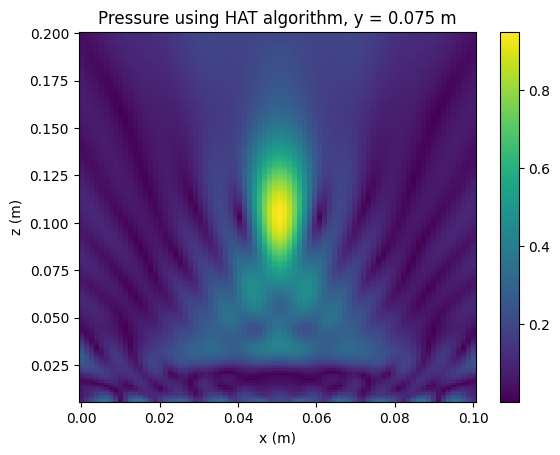

In [11]:
plt.pcolormesh(np.linspace(0, 0.1, n), np.linspace(0, 0.2, 2*n)[5:], norm[60, :, :].swapaxes(0, 1))
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.title(f"Pressure using HAT algorithm, y = {0.1 / n * 60} m")

In [12]:
x, y, z = np.where(np.abs(mesh)/np.max(np.abs(mesh))>0.8)

In [13]:
xx, yy = np.meshgrid(x, y)

NameError: name 'pcolormesh' is not defined

In [15]:
theta = np.linspace(-np.pi/2, np.pi/2, 100)
a = 0.005
H = np.abs(2 * sp.special.j1(k * a * np.sin(theta)) / ( k * a * np.sin(theta)))

Text(0.5, 1.0, 'Directionality of a 10mm piston source, ka = 3.69')

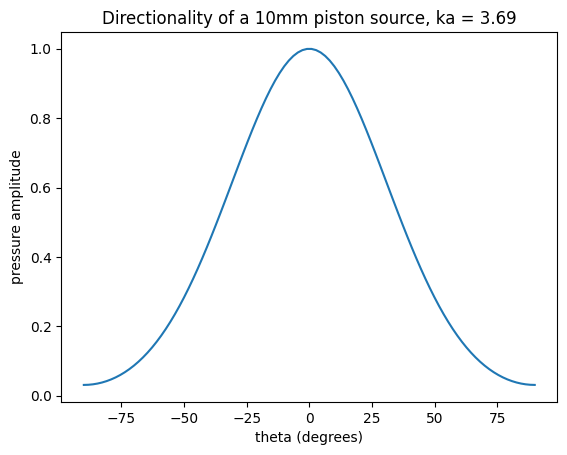

In [17]:
plt.plot(theta * 180 / np.pi, H)
plt.xlabel("theta (degrees)")
plt.ylabel("pressure amplitude")
plt.title(f"Directionality of a 10mm piston source, ka = {k * a:.3}")

In [7]:
import hat
phases = hat.run_hat([[0.05, 0.05, 0.05]], phase_res=32, z=0.14)

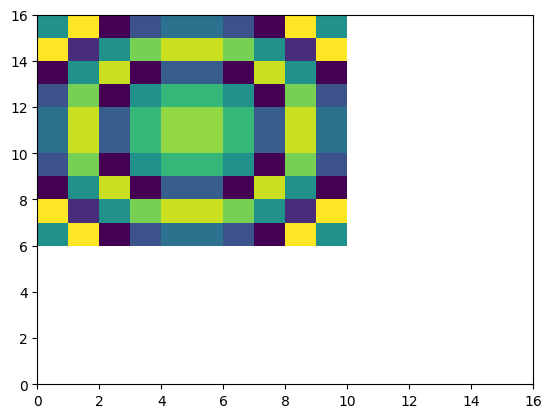

In [8]:
import matplotlib.pyplot as plt
import numpy as np
EMITTERS_ORDER = [0, 7, 1, 2, 64, 71, 65, 66, 128, 135, 129, 130, 192, 199, 193, 194, 4, 3, 6, 5, 68, 67, 70, 69, 132, 131, 134, 133, 196, 195, 198, 197, 8, 15, 9, 10, 72, 79, 73, 74, 136, 143, 137, 138, 200, 207, 201, 202, 12, 11, 14, 13, 76, 75, 78, 77, 140, 139, 142, 141, 204, 203, 206, 205, 16, 23, 17, 18, 80, 87, 81, 82, 144, 151, 145, 146, 208, 215, 209, 210, 20, 19, 22, 21, 84, 83, 86, 85, 148, 147, 150, 149, 212, 211, 214, 213, 24, 31, 25, 26, 88, 95, 89, 90, 152, 159, 153, 154, 216, 223, 217, 218, 28, 27, 30, 29, 92, 91, 94, 93, 156, 155, 158, 157, 220, 219, 222, 221, 32, 39, 33, 34, 96, 103, 97, 98, 160, 167, 161, 162, 224, 231, 225, 226, 36, 35, 38, 37, 100, 99, 102, 101, 164, 163, 166, 165, 228, 227, 230, 229, 40, 47, 41, 42, 104, 111, 105, 106, 168, 175, 169, 170, 232, 239, 233, 234, 44, 43, 46, 45, 108, 107, 110, 109, 172, 171, 174, 173, 236, 235, 238, 237, 48, 55, 49, 50, 112, 119, 113, 114, 176, 183, 177, 178, 240, 247, 241, 242, 52, 51, 54, 53, 116, 115, 118, 117, 180, 179, 182, 181, 244, 243, 246, 245, 56, 63, 57, 58, 120, 127, 121, 122, 184, 191, 185, 186, 248, 255, 249, 250, 60, 59, 62, 61, 124, 123, 126, 125, 188, 187, 190, 189, 252, 251, 254, 253]
phases_fix = np.pad(phases, [(6, 0), (0, 6)], constant_values=np.NaN)
plt.pcolormesh(np.angle(phases_fix))

In [6]:
np.ceil(np.abs(phases_fix.flatten())) * EMITTERS_ORDER

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  24.,  31.,  25.,
        26.,  88.,  95.,  89.,  90., 152., 159.,  nan,  nan,  nan,  nan,
        nan,  nan,  28.,  27.,  60.,  29.,  92.,  91.,  94., 186., 156.,
       155.,  nan,  nan,  nan,  nan,  nan,  nan,  32.,  78.,  33.,  34.,
        96., 103.,  97.,  98., 320., 167.,  nan,  nan,  nan,  nan,  nan,
        nan,  36.,  35.,  38.,  37., 100.,  99., 10

In [7]:
phases.shape

(10, 10)

In [8]:
on = b'\xc0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x08\x02\x02\x01\x00\x08\x06\x00\x03\x04\x04\x04\x03\x06\x05\x02\x04\x03\x1f\x1f\x04\x08\x01\x05\x06\x06\x01\x01\x00\t\x01\x02\x06\x01\x04\x08\x01\x07\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x06\x04\x05\x06\x07\x06\x02\x02\x05\x1e\x03\x04\x02\x05\x1e\x06\x04\x02\x04\x00\x05\x04\x1f\x03\x03\x04\x00\x1f\x01\x05\x04\x04\x00\x07\x03\x05\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x07\x07\x00\x00\t\x07\x00\x00\x06\x03\x00\x00\x03\x02\x00\x00\x08\x06\x00\x00\x03\x01\x00\x00\x04\x03\x00\x00\x06\x02\x00\x00\x04\x03\x00\x00\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfd'
on = b'\xC0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x08\x1A\x00\x1C\x11\x0A\x04\x12\x18\x0C\x12\x08\x1D\x16\x11\x03\x1F\x13\x19\x0A\x1F\x18\x12\x0A\x1B\x0F\x15\x00\x16\x0F\x09\x06\x0D\x00\x06\x0D\x03\x1B\x15\x18\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x01\x1D\x0E\x0D\x07\x0B\x04\x15\x13\x0E\x1A\x1A\x13\x18\x15\x1C\x1A\x15\x1C\x1B\x14\x19\x1C\x18\x16\x11\x12\x12\x0B\x10\x18\x09\x07\x03\x1E\x1E\x18\x1C\x0A\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x15\x00\x00\x15\x1F\x00\x00\x0C\x06\x00\x00\x01\x0B\x00\x00\x1C\x0D\x00\x00\x03\x0D\x00\x00\x03\x09\x00\x00\x1A\x04\x00\x00\x1F\x1B\x00\x00\x07\x10\x00\x00\x11\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfd'

In [9]:
real_data = np.frombuffer(on[1:-1], dtype=np.uint8)

In [15]:
phases = np.angle(phases_fix).flatten() + np.pi
deactivated = np.isnan(phases)
phases = (phases % (2*np.pi)) * 32 / 2 / np.pi
phases[deactivated] = 32
dataToSend = np.empty(phases.size, np.uint8)
order = EMITTERS_ORDER
dataToSend[order] = phases

In [16]:
dataToSend[np.where(dataToSend == 32)] = 0

In [17]:
np.sum((real_data + dataToSend) > 0)

100

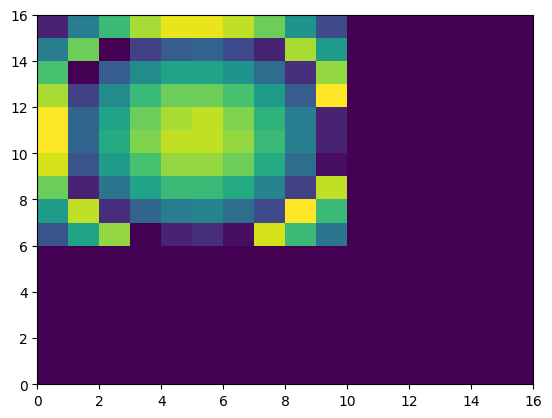

In [18]:
plt.pcolormesh(real_data[EMITTERS_ORDER].reshape([16, 16]))

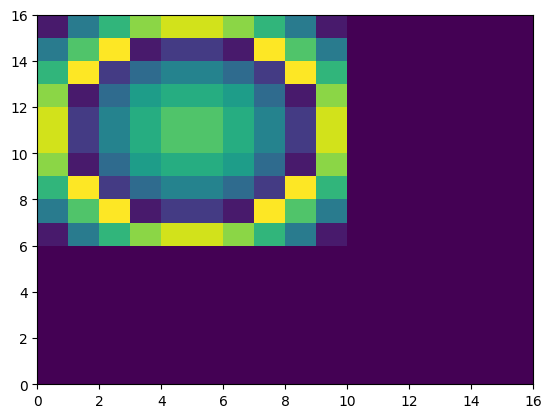

In [19]:
plt.pcolormesh(dataToSend[EMITTERS_ORDER].reshape([16, 16]))

In [4]:
z = 0.14
tx, ty = np.meshgrid(np.linspace(0.005, 0.095, 10), np.linspace(0.005, 0.095, 10))
transducers = np.stack([tx.flatten(), ty.flatten(), np.zeros([100]) + z], axis=1)

In [5]:
transducers.shape

(100, 3)

In [7]:
transducers * [1, 1, -1]

array([[ 0.005,  0.005, -0.14 ],
       [ 0.015,  0.005, -0.14 ],
       [ 0.025,  0.005, -0.14 ],
       [ 0.035,  0.005, -0.14 ],
       [ 0.045,  0.005, -0.14 ],
       [ 0.055,  0.005, -0.14 ],
       [ 0.065,  0.005, -0.14 ],
       [ 0.075,  0.005, -0.14 ],
       [ 0.085,  0.005, -0.14 ],
       [ 0.095,  0.005, -0.14 ],
       [ 0.005,  0.015, -0.14 ],
       [ 0.015,  0.015, -0.14 ],
       [ 0.025,  0.015, -0.14 ],
       [ 0.035,  0.015, -0.14 ],
       [ 0.045,  0.015, -0.14 ],
       [ 0.055,  0.015, -0.14 ],
       [ 0.065,  0.015, -0.14 ],
       [ 0.075,  0.015, -0.14 ],
       [ 0.085,  0.015, -0.14 ],
       [ 0.095,  0.015, -0.14 ],
       [ 0.005,  0.025, -0.14 ],
       [ 0.015,  0.025, -0.14 ],
       [ 0.025,  0.025, -0.14 ],
       [ 0.035,  0.025, -0.14 ],
       [ 0.045,  0.025, -0.14 ],
       [ 0.055,  0.025, -0.14 ],
       [ 0.065,  0.025, -0.14 ],
       [ 0.075,  0.025, -0.14 ],
       [ 0.085,  0.025, -0.14 ],
       [ 0.095,  0.025, -0.14 ],
       [ 0